# name cloze eval
- create new columns for name predicted 
- per record 
- check for fuzzy and exact match of ent in list
    - Unidecode and naming variation package

In [46]:
import pandas as pd
import unidecode
from fuzzywuzzy import fuzz
import re
import matplotlib.pyplot as plt
import ast

In [47]:
df = pd.read_csv('/Users/alishasrivastava/Desktop/huckleberry finn results/Adventures_of_Huckleberry_Finn_nct_gpt4o.csv')
df.drop(columns=['en_correctness', 'es_correctness', 'tr_correctness', 'vi_correctness'], inplace=True)
df['Single_ent'] = df['Single_ent'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
for col in ['en_results', 'tr_results', 'vi_results', 'es_results']:
    df[col] = df[col].astype(str)
df

,Single_ent,en,en_results,es,es_results,tr,tr_results,vi,vi_results
0,"[musa, moisés, moses]","Pretty soon I wanted to smoke, and asked the w...",Huck,En seguida me daban ganas de fumar y le pedía ...,Huckleberry Finn,Bir süre sonra canım tütün çekti ve dul bayand...,Sigmund Freud,"Lát sau tôi muốn hút thuốc, tôi mới bảo bà goá...",Hamlet
1,[tom sawyer],"Now she had got a start, and she went on and t...",Tom,Entonces ella se lanzaba a contarme todo lo de...,Tom,"Artık çenesi açılmıştı, iyi yer hakkında ne va...",Robin,Cô ấy bảo đi đến chỗ đó thì người ta suốt ngày...,Cuội
2,"[bayan watson, watson]","Miss [MASK] she kept pecking at me, and it got...",Watson,Un día la señorita [MASK] no paraba de meterse...,Watson,[MASK] nasihatlerini ve azarlarını peş peşe sı...,Jim,"Cô [MASK] cứ bắt tôi mãi như vậy, thật là khó ...",Rebecca
3,[tom sawyer],"I set down again, a-shaking all over, and got ...",Tom,"Volví a sentarme, todo tiritando, y saqué la p...",Tom,Zangır zangır titreyerek tekrar oturdum ve içm...,Tom,"Tôi lại ngồi xuống ghế, trong người bối rối kh...",Tom
4,[tom],"We went to a clump of bushes, and [MASK] made ...",Tom,Fuimos a una mata de arbustos y [MASK] hizo qu...,Tom,Bir çalı kümesinin oraya gittik ve [MASK] herk...,Tom,Bọn chúng tôi đi đến một bụi rậm cây cối chi c...,Tom
...,...,...,...,...,...,...,...,...,...
140,[phelps],"“Why, dog my cats, they must a ben a house-ful...",Hotchkiss,"—Bueno, que me ahorquen, tiene que haber habid...",Watson,"“Ay, üstüme iyilik sağlık, [MASK] Kardeş, dört...",Tom,"- Quái lạ, hắn đêm nào cũng phải có một đám da...",Phương
141,[sid],And then when I went up to bed she come up wit...,Tom,"Y después, cuando me fui a la cama, subió conm...",Tom,Sonra ben yatmaya giderken şamdanını alıp beni...,David,"Dì ấy cũng đem cây nến lên theo, dắt tôi vào t...",Huck
142,[jim],"They cussed [MASK] considerble, though, and gi...",Jim,Llamaron de todo a [MASK] y le dieron de golpe...,Jim,Yine de [MASK]’e sayıp sövdüler birkaç kez vur...,Jean Valjean,Chốc chốc lại có người đá cho [MASK] một cái. ...,MASK
143,[jim],"Then the others softened up a little, too, and...",Jim,Entonces también los demás se ablandaron un po...,Sancho,"Sonra diğerleri de biraz yumuşadı, [MASK]’e bu...",Jim,Rồi những người khác cũng dịu đi đôi chút. Tôi...,Người


In [53]:
def is_string(value):
    if isinstance(value, str):
        normalized_value = unidecode.unidecode(value)
        return normalized_value.replace(" ", "").isalpha()
    return False

for col in ['en_results', 'tr_results', 'vi_results', 'es_results']:
    for value in df[col]:
        if not is_string(value):
            print(f"Invalid '{col}': {value}")
      

Invalid 'vi_results': [MASK]


In [52]:
def calculate_match_scores(ents_list, en_result):
    en_result_normalized = unidecode.unidecode(en_result).lower().strip()
    
    exact_match = 0
    highest_fuzzy_score = 0
    
    for ent in ents_list:
        ent_normalized = unidecode.unidecode(ent).lower().strip()
        if ent_normalized == en_result_normalized:
            exact_match = 1
        
        fuzzy_score = fuzz.ratio(ent_normalized, en_result_normalized)/ 100
        highest_fuzzy_score = max(highest_fuzzy_score, fuzzy_score)
    
    return exact_match, highest_fuzzy_score

df['en_exact_match'], df['en_highest_fuzzy_match'] = zip(*df.apply(lambda row: calculate_match_scores(row['Single_ent'], row['en_results']), axis=1))
df['es_exact_match'], df['es_highest_fuzzy_match'] = zip(*df.apply(lambda row: calculate_match_scores(row['Single_ent'], row['es_results']), axis=1))
df['vi_exact_match'], df['vi_highest_fuzzy_match'] = zip(*df.apply(lambda row: calculate_match_scores(row['Single_ent'], row['vi_results']), axis=1))
df['tr_exact_match'], df['tr_highest_fuzzy_match'] = zip(*df.apply(lambda row: calculate_match_scores(row['Single_ent'], row['tr_results']), axis=1))
df

,Single_ent,en,en_results,es,es_results,tr,tr_results,vi,vi_results,exact_match,fuzzy_match,en_exact_match,en_highest_fuzzy_match,es_exact_match,es_highest_fuzzy_match,vi_exact_match,vi_highest_fuzzy_match,tr_exact_match,tr_highest_fuzzy_match
0,"[musa, moisés, moses]","Pretty soon I wanted to smoke, and asked the w...",Huck,En seguida me daban ganas de fumar y le pedía ...,Huckleberry Finn,Bir süre sonra canım tütün çekti ve dul bayand...,Sigmund Freud,"Lát sau tôi muốn hút thuốc, tôi mới bảo bà goá...",Hamlet,0,0.25,0,0.25,0,0.10,0,0.36,0,0.24
1,[tom sawyer],"Now she had got a start, and she went on and t...",Tom,Entonces ella se lanzaba a contarme todo lo de...,Tom,"Artık çenesi açılmıştı, iyi yer hakkında ne va...",Robin,Cô ấy bảo đi đến chỗ đó thì người ta suốt ngày...,Cuội,0,0.46,0,0.46,0,0.46,0,0.14,0,0.13
2,"[bayan watson, watson]","Miss [MASK] she kept pecking at me, and it got...",Watson,Un día la señorita [MASK] no paraba de meterse...,Watson,[MASK] nasihatlerini ve azarlarını peş peşe sı...,Jim,"Cô [MASK] cứ bắt tôi mãi như vậy, thật là khó ...",Rebecca,1,1.00,1,1.00,1,1.00,0,0.21,0,0.00
3,[tom sawyer],"I set down again, a-shaking all over, and got ...",Tom,"Volví a sentarme, todo tiritando, y saqué la p...",Tom,Zangır zangır titreyerek tekrar oturdum ve içm...,Tom,"Tôi lại ngồi xuống ghế, trong người bối rối kh...",Tom,0,0.46,0,0.46,0,0.46,0,0.46,0,0.46
4,[tom],"We went to a clump of bushes, and [MASK] made ...",Tom,Fuimos a una mata de arbustos y [MASK] hizo qu...,Tom,Bir çalı kümesinin oraya gittik ve [MASK] herk...,Tom,Bọn chúng tôi đi đến một bụi rậm cây cối chi c...,Tom,1,1.00,1,1.00,1,1.00,1,1.00,1,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,[phelps],"“Why, dog my cats, they must a ben a house-ful...",Hotchkiss,"—Bueno, que me ahorquen, tiene que haber habid...",Watson,"“Ay, üstüme iyilik sağlık, [MASK] Kardeş, dört...",Tom,"- Quái lạ, hắn đêm nào cũng phải có một đám da...",Phương,0,0.27,0,0.27,0,0.17,0,0.33,0,0.00
141,[sid],And then when I went up to bed she come up wit...,Tom,"Y después, cuando me fui a la cama, subió conm...",Tom,Sonra ben yatmaya giderken şamdanını alıp beni...,David,"Dì ấy cũng đem cây nến lên theo, dắt tôi vào t...",Huck,0,0.00,0,0.00,0,0.00,0,0.00,0,0.50
142,[jim],"They cussed [MASK] considerble, though, and gi...",Jim,Llamaron de todo a [MASK] y le dieron de golpe...,Jim,Yine de [MASK]’e sayıp sövdüler birkaç kez vur...,Jean Valjean,Chốc chốc lại có người đá cho [MASK] một cái. ...,MASK,1,1.00,1,1.00,1,1.00,0,0.29,0,0.13
143,[jim],"Then the others softened up a little, too, and...",Jim,Entonces también los demás se ablandaron un po...,Sancho,"Sonra diğerleri de biraz yumuşadı, [MASK]’e bu...",Jim,Rồi những người khác cũng dịu đi đôi chút. Tôi...,Người,1,1.00,1,1.00,0,0.00,0,0.25,1,1.00


In [61]:
def assess(language, df, threshold=0.7):
    df[f'{language}_fuzzy_to_exact_ratio'] = (
        df[f'{language}_highest_fuzzy_match'] / df[f'{language}_exact_match']
    ).replace([float('inf'), -float('inf')], 0).fillna(0)

    df[f'{language}_correct'] = df[f'{language}_fuzzy_to_exact_ratio'].apply(
        lambda x: 'correct' if x >= threshold else 'incorrect'
    )

for language in ['en', 'es', 'vi', 'tr']:
    assess(language, df)
df

,Single_ent,en,en_results,es,es_results,tr,tr_results,vi,vi_results,exact_match,...,tr_exact_match,tr_highest_fuzzy_match,en_fuzzy_to_exact_ratio,en_correct,es_fuzzy_to_exact_ratio,es_correct,vi_fuzzy_to_exact_ratio,vi_correct,tr_fuzzy_to_exact_ratio,tr_correct
0,"[musa, moisés, moses]","Pretty soon I wanted to smoke, and asked the w...",Huck,En seguida me daban ganas de fumar y le pedía ...,Huckleberry Finn,Bir süre sonra canım tütün çekti ve dul bayand...,Sigmund Freud,"Lát sau tôi muốn hút thuốc, tôi mới bảo bà goá...",Hamlet,0,...,0,0.24,0.0,incorrect,0.0,incorrect,0.0,incorrect,0.0,incorrect
1,[tom sawyer],"Now she had got a start, and she went on and t...",Tom,Entonces ella se lanzaba a contarme todo lo de...,Tom,"Artık çenesi açılmıştı, iyi yer hakkında ne va...",Robin,Cô ấy bảo đi đến chỗ đó thì người ta suốt ngày...,Cuội,0,...,0,0.13,0.0,incorrect,0.0,incorrect,0.0,incorrect,0.0,incorrect
2,"[bayan watson, watson]","Miss [MASK] she kept pecking at me, and it got...",Watson,Un día la señorita [MASK] no paraba de meterse...,Watson,[MASK] nasihatlerini ve azarlarını peş peşe sı...,Jim,"Cô [MASK] cứ bắt tôi mãi như vậy, thật là khó ...",Rebecca,1,...,0,0.00,1.0,correct,1.0,correct,0.0,incorrect,0.0,incorrect
3,[tom sawyer],"I set down again, a-shaking all over, and got ...",Tom,"Volví a sentarme, todo tiritando, y saqué la p...",Tom,Zangır zangır titreyerek tekrar oturdum ve içm...,Tom,"Tôi lại ngồi xuống ghế, trong người bối rối kh...",Tom,0,...,0,0.46,0.0,incorrect,0.0,incorrect,0.0,incorrect,0.0,incorrect
4,[tom],"We went to a clump of bushes, and [MASK] made ...",Tom,Fuimos a una mata de arbustos y [MASK] hizo qu...,Tom,Bir çalı kümesinin oraya gittik ve [MASK] herk...,Tom,Bọn chúng tôi đi đến một bụi rậm cây cối chi c...,Tom,1,...,1,1.00,1.0,correct,1.0,correct,1.0,correct,1.0,correct
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,[phelps],"“Why, dog my cats, they must a ben a house-ful...",Hotchkiss,"—Bueno, que me ahorquen, tiene que haber habid...",Watson,"“Ay, üstüme iyilik sağlık, [MASK] Kardeş, dört...",Tom,"- Quái lạ, hắn đêm nào cũng phải có một đám da...",Phương,0,...,0,0.00,0.0,incorrect,0.0,incorrect,0.0,incorrect,0.0,incorrect
141,[sid],And then when I went up to bed she come up wit...,Tom,"Y después, cuando me fui a la cama, subió conm...",Tom,Sonra ben yatmaya giderken şamdanını alıp beni...,David,"Dì ấy cũng đem cây nến lên theo, dắt tôi vào t...",Huck,0,...,0,0.50,0.0,incorrect,0.0,incorrect,0.0,incorrect,0.0,incorrect
142,[jim],"They cussed [MASK] considerble, though, and gi...",Jim,Llamaron de todo a [MASK] y le dieron de golpe...,Jim,Yine de [MASK]’e sayıp sövdüler birkaç kez vur...,Jean Valjean,Chốc chốc lại có người đá cho [MASK] một cái. ...,MASK,1,...,0,0.13,1.0,correct,1.0,correct,0.0,incorrect,0.0,incorrect
143,[jim],"Then the others softened up a little, too, and...",Jim,Entonces también los demás se ablandaron un po...,Sancho,"Sonra diğerleri de biraz yumuşadı, [MASK]’e bu...",Jim,Rồi những người khác cũng dịu đi đôi chút. Tôi...,Người,1,...,1,1.00,1.0,correct,0.0,incorrect,0.0,incorrect,1.0,correct


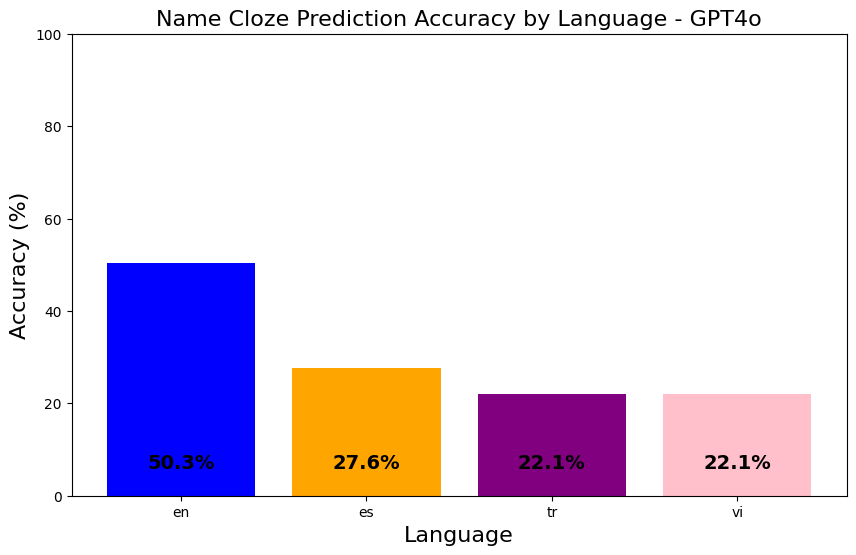

In [62]:
total_observations = len(df)
author_accuracy = {
    'en': df['en_correct'].value_counts(normalize=True)['correct'] * 100,
    'es': df['es_correct'].value_counts(normalize=True)['correct'] * 100,
    'tr': df['tr_correct'].value_counts(normalize=True)['correct'] * 100,
    'vi': df['vi_correct'].value_counts(normalize=True)['correct'] * 100
}

languages = list(author_accuracy.keys())
accuracy_values = list(author_accuracy.values())
plt.figure(figsize=(10, 6))
bars = plt.bar(languages, accuracy_values, color=['blue', 'green', 'red', 'purple'])

plt.bar(languages, accuracy_values, color=['blue', 'orange', 'purple', 'pink'])
plt.rcParams.update({'font.size': 14}) 

plt.xlabel('Language', fontsize=16)
plt.ylabel('Accuracy (%)', fontsize=16)
plt.title('Name Cloze Prediction Accuracy by Language - GPT4o', fontsize=16)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, 5, f'{height:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')  # Bold formatting added here

plt.ylim(0, 100)
plt.show()